In [1]:
from time import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
import warnings
warnings.filterwarnings('ignore')
import pysensors as ps
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
from IPython.display import HTML
HTML("""
<style>
.output {
    display: flex;
    text-align: center;
    vertical-align: center;
    margins:auto
}
</style>
""")

In [3]:
## Load data for Opti-TWIST prototype:

import pandas as pd
df = pd.read_csv('~/projects/sparse_sensing_in_ndts-ldrd/data/0_raw/004_BB_7Power_7BC/650_420.csv')
df

,Temperature (K),Velocity[i] (m/s),Velocity[j] (m/s),X (m),Y (m),Z (m)
0,526.648511,1.79769313486232e+308,1.79769313486232e+308,0.002953,-0.017654,0
1,526.645400,1.79769313486232e+308,1.79769313486232e+308,0.002982,-0.017977,0
2,526.669124,1.79769313486232e+308,1.79769313486232e+308,0.002863,-0.017775,0
3,526.738401,1.79769313486232e+308,1.79769313486232e+308,0.002503,-0.017575,0
4,526.668918,1.79769313486232e+308,1.79769313486232e+308,0.002881,-0.018116,0
...,...,...,...,...,...,...
40505,420.000000,1.79769313486232e+308,1.79769313486232e+308,0.044450,-0.237005,0
40506,420.000000,1.79769313486232e+308,1.79769313486232e+308,0.044450,-0.239735,0
40507,420.000000,1.79769313486232e+308,1.79769313486232e+308,0.044450,-0.242478,0
40508,420.000000,1.79769313486232e+308,1.79769313486232e+308,0.044450,-0.245220,0


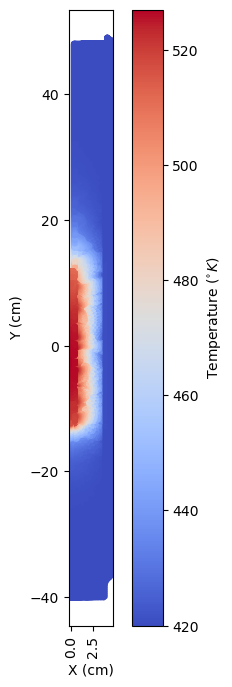

In [4]:
## Temperature profile of Opti-TWIST prototype:

X,Y = df['X (m)'], df['Y (m)']
fig = plt.figure(figsize=(5,8))
plt.scatter(X*100,Y*100, s=10, c=df['Temperature (K)'],cmap=plt.cm.coolwarm)
plt.xlabel('X (cm)')
plt.tick_params(axis='x', labelrotation = 90)
plt.ylabel('Y (cm)')
cbar = plt.colorbar()
cbar.set_label('Temperature ($^{\circ}K$)')
axes=plt.gca()
axes.set_aspect(0.7)

In [5]:
## Data preprocessing, Wrangling, Cleansing and Scraping

Responses = ['Temperature (K)','Velocity[i] (m/s)','Velocity[j] (m/s)']
RoI = Responses[0]
filename = "~/projects/sparse_sensing_in_ndts-ldrd/data/0_raw/004_BB_7Power_7BC/"
data = np.zeros((40510,49))
counter = -1
for j,i in enumerate(np.arange(350,700,50)):
    for l,k in enumerate(np.arange(240,450,30)):
        df = pd.read_csv(filename + str(i) + '_' + str(k) + '.csv')
        counter += 1
        if i == 650 and k == 420:
            print(counter)
        for n in range(3):     
            df[Responses[n]].replace(to_replace='1.79769313486232e+308', value=0.0, inplace=True)
        data[:,counter] = df[RoI]

48


In [6]:
data = data.T
print(np.shape(data))
df

(49, 40510)


,Temperature (K),Velocity[i] (m/s),Velocity[j] (m/s),X (m),Y (m),Z (m)
0,526.648511,0.0,0.0,0.002953,-0.017654,0
1,526.645400,0.0,0.0,0.002982,-0.017977,0
2,526.669124,0.0,0.0,0.002863,-0.017775,0
3,526.738401,0.0,0.0,0.002503,-0.017575,0
4,526.668918,0.0,0.0,0.002881,-0.018116,0
...,...,...,...,...,...,...
40505,420.000000,0.0,0.0,0.044450,-0.237005,0
40506,420.000000,0.0,0.0,0.044450,-0.239735,0
40507,420.000000,0.0,0.0,0.044450,-0.242478,0
40508,420.000000,0.0,0.0,0.044450,-0.245220,0


In [7]:
## Find all sensor locations using built in QR optimizer

n_sensors = 8
n_modes = 8
basis = ps.basis.SVD(n_basis_modes=n_modes)
optimizer  = ps.optimizers.QR()
model = ps.SSPOR(basis=basis, optimizer=optimizer, n_sensors=n_sensors)
model.fit(data)
all_sensors = model.get_all_sensors()
sensors = model.get_selected_sensors()

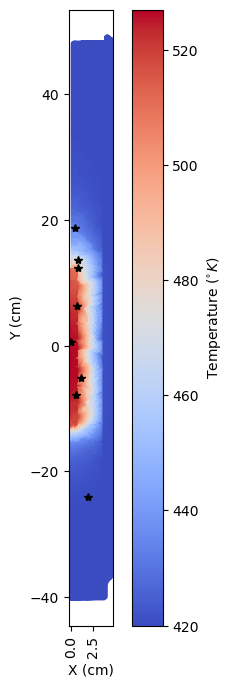

In [8]:
## Sensor locations on the grid:

yUnconstrained = df['Y (m)'][sensors]
xUnconstrained = df['X (m)'][sensors]

X,Y = df['X (m)'], df['Y (m)']
fig = plt.figure(figsize=(5,8))
plt.scatter(X*100,Y*100, s=10, c=df['Temperature (K)'],cmap=plt.cm.coolwarm)
plt.xlabel('X (cm)')
plt.tick_params(axis='x', labelrotation = 90)
plt.ylabel('Y (cm)')
cbar = plt.colorbar()
cbar.set_label('Temperature ($^{\circ}K$)')
plt.plot(xUnconstrained*100,yUnconstrained*100,'*k')
axes=plt.gca()
axes.set_aspect(0.7)

In [9]:
xUnc, yUnc = ps.utils._constraints.get_coordinates_from_indices(sensors,df)


### Functional constaints:

Suppose the user wants to constrain a circular aea centered at x = 0.025 m, y = 0 m with a radius (r = 0.02 m)

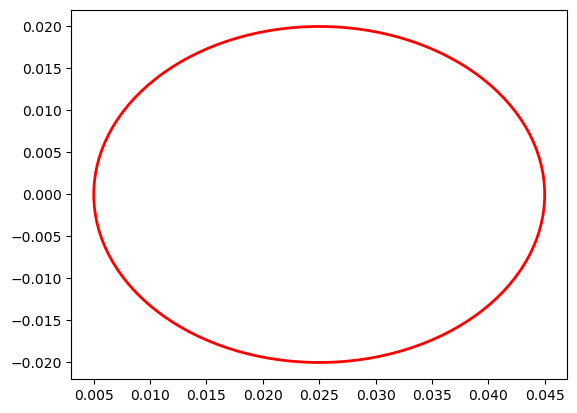

In [10]:
circle = ps.utils._constraints.Circle(center_x = 0.025, center_y = 0, radius = 0.02, data = df, Y_axis = 'Y (m)', X_axis = 'X (m)', Field = 'Temperature (K)') #Plotting the constrained circle 
circle.draw_constraint() ###Plotting just the constraint

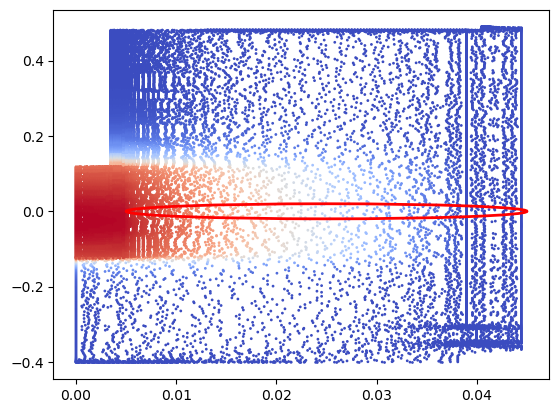

In [11]:
circle.plot_constraint_on_data(plot_type='contour_map') ##Plotting the constraint on the data

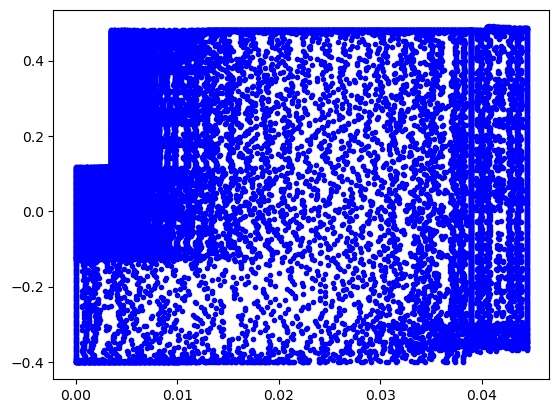

In [12]:
circle.plot_grid(all_sensors=all_sensors)

### Obtaining constrained indices :

In [13]:
const_idx, rank = circle.get_constraint_indices(all_sensors = all_sensors,info=df)  

In [14]:
# Define the number of constrained sensors allowed (s)
n_const_sensors = 1

# Define the GQR optimizer for the exact_n sensor placement strategy
optimizer_circle = ps.optimizers.GQR()
opt_exact_kws={'idx_constrained':const_idx,
         'n_sensors':n_sensors,
         'n_const_sensors':n_const_sensors,
         'all_sensors':all_sensors,
         'constraint_option':"exact_n"}
basis_exact = ps.basis.SVD(n_basis_modes=n_sensors)

In [15]:
# Initialize and fit the model
model_exact = ps.SSPOR(basis = basis_exact, optimizer = optimizer_circle, n_sensors = n_sensors)
model_exact.fit(data,**opt_exact_kws)

# sensor locations based on columns of the data matrix
top_sensors_exact = model_exact.get_selected_sensors()

# sensor locations based on pixels of the image
xCircle, yCircle = ps.utils._constraints.get_coordinates_from_indices(top_sensors_exact,df)

print('The list of sensors selected is: {}'.format(top_sensors_exact))

The list of sensors selected is: [15658 18378 29993 16573 31414 40090 21456 14338]


In [16]:
data_sens_circle = circle.sensors_dataframe(sensors = top_sensors_exact)
data_sens_circle

,Sensor ID,SensorX,sensorY
0,15658.0,0.008200,0.136713
1,18378.0,0.006977,0.063449
2,29993.0,0.011413,-0.051947
3,16573.0,0.007676,0.124104
4,31414.0,0.006206,-0.079055
5,40090.0,0.019092,-0.241529
6,21456.0,0.004899,0.187096
7,14338.0,0.000430,0.053404


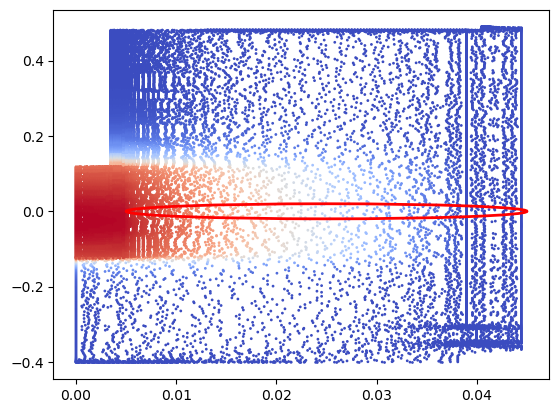

In [17]:
circle.plot_constraint_on_data(plot_type='contour_map')
circle.annotate_sensors(sensors = top_sensors_exact)